## Author : Isaac Sihlangu

## Prediction of terrosist attack perpetrator

In [1]:
#Importing important modules
import pandas as pd # Data manipulations
import matplotlib.pylab as plt # Data visualization
import numpy as np  # Basic statistics and data manipulation
from collections import Counter
import seaborn as sns

# Feature selection
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Loading Machine Learning Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm


## Project description
In this project we are going to build a models that can predict which terrorist group may have been responsible for the terrorist attack incident. Features like weapon, attack type and many more others will be used to predict.

## Data Description
Global Terrorism Database (GTD) is an open-source database including information on terrorist events around the world from 1970 through 2014. Some portion of the attacks have not been attributed to a particular terrorist group.

## Loading in the data

In [2]:
# Read in the data using pandas
data = pd.read_excel('globalterrorismdb_0617dist.xlsx')

## Data Pre-processing

In [3]:
# Viewing the data
data.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaT,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaT,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaT,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaT,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaT,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [4]:
print '========================================================================================================='
print 'The number of training examples is ',data.shape[0],'and number of attributes is',data.shape[1]
print '========================================================================================================='

The number of training examples is  170350 and number of attributes is 135


This data was collected from different sources, that would result in data inconsistance. To solve the problem, we are going to remove all the unknown targets name. Removing the unknown group is motivated by the fact that  we don't know which group does the unknown belong too, and as such we cannot classify them as one group since the data was collected from different resources. It might happen that the incident was from different types of groups which then will be classified as the unknown in our dataset.

In [5]:
# Getting all the known terosit group name from the dataset.
unknown_g = [ngroup for ngroup in data['gname'] if ngroup=='Unknown']
print '=========================================================================================================='
print 'The total number of terrosist groups: ',len(data['gname'].unique())
print 'The percentage of the unkwonn groups out of the whole dataset is : ',float(len(unknown_g))/len(data['gname'])*100,'%'
print '=========================================================================================================='

The total number of terrosist groups:  3454
The percentage of the unkwonn groups out of the whole dataset is :  45.967713531 %


We can note that from above the unknown group is the most common group in the dataset, about 54% of the dataset is from the unknown group. So this results furthur motivate why we should remove the unknown group, because if we train the classifier with the unknown, this will result in biased results, since we do not know which class does the unknown fall under. Again since the data was collected from different source, we will set a threshold in which we will remove all the groups with less than 10 attacks reported.

In [6]:
# Selecting only the data with the known groups and removing groups with 10 attacks or less
filtereddata =data[data['gname']!='Unknown'] 
fg = []    # Filtered groups
for tgroup, number in  Counter(data['gname']).items():
    if number > 10:
        fg.append(tgroup)
        
filtereddata=filtereddata[filtereddata['gname'].isin(fg)]

In [7]:
print '========================================================================================================='
print 'The number of training examples is ',filtereddata.shape[0],'and number of attributes is',filtereddata.shape[1]
print '========================================================================================================='

The number of training examples is  85522 and number of attributes is 135


We can note the number of training example went down after removing the inconsistant data. Now we are going to check if our features cointains some nan values.

In [8]:
counter = 0
for feature in data.columns:
    if filtereddata[feature].isnull().sum() !=0:
        counter += 1
print '========================================================================================================='
print 'Number of features that cointains nan values is them', counter, 'out of',filtereddata.shape[1]
print '========================================================================================================='

Number of features that cointains nan values is them 104 out of 135


In [9]:
filt = filtereddata 

We can note that all the columns/features contains null values in them, so we are going to remove all the features that has 80% of null values.

In [10]:
# Dropping all the features with more than 80% of values which are null
for feature in filtereddata.columns:
    perc = filtereddata[str(feature)].isnull().sum()/float(len(filtereddata))# Percentage of null values in a column
    if perc >= 0.8:
        filtereddata = filtereddata.drop(feature,1)

After removing columns/features that coitains 80% of null values the number of features/columns went down.

In [11]:
print '========================================================================================================='
print 'Number of traning examples',filtereddata.shape[0],' and number of features is ',filtereddata.shape[1]
print '========================================================================================================='

Number of traning examples 85522  and number of features is  67


Below we are going to look at basic statistics of the data.

In [12]:
filtereddata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
eventid,85522.0,1.999853e+11,1.372294e+09,1.970000e+11,1.988033e+11,2.001081e+11,2.014041e+11,2.017013e+11
iyear,85522.0,1.999787e+03,1.372222e+01,1.970000e+03,1.988000e+03,2.001000e+03,2.014000e+03,2.016000e+03
imonth,85522.0,6.475994e+00,3.378995e+00,0.000000e+00,4.000000e+00,6.000000e+00,9.000000e+00,1.200000e+01
iday,85522.0,1.541431e+01,8.760658e+00,0.000000e+00,8.000000e+00,1.500000e+01,2.300000e+01,3.100000e+01
extended,85522.0,5.536587e-02,2.286943e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
country,85522.0,1.411322e+02,1.276666e+02,4.000000e+00,6.100000e+01,1.380000e+02,1.820000e+02,1.004000e+03
region,85522.0,6.719195e+00,3.061465e+00,1.000000e+00,3.000000e+00,6.000000e+00,1.000000e+01,1.200000e+01
latitude,82437.0,2.137030e+01,1.962933e+01,-5.315461e+01,7.689167e+00,2.509607e+01,3.499591e+01,6.040393e+01
longitude,82437.0,1.746738e+01,6.306569e+01,-1.578190e+02,-7.319996e+00,3.510225e+01,6.736875e+01,1.793667e+02
specificity,85520.0,1.542703e+00,1.087890e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00


We are going to check the kind of data that our data cointains. Looking at the table above we can emmidiately tell that we have missing values on some of the attributes. We need to take care of those missing values by replacing them by the median value so that we can be able to perform some computation without running into erros. This choice is largely motivated by the following reasons simplicity and performance. 
The maximum number of counts that we can see from the above table is 85522, so we are going to search for all those attributes with less count so that we can remove them with 0.

In [13]:
filtereddata.dtypes

eventid               int64
iyear                 int64
imonth                int64
iday                  int64
extended              int64
country               int64
country_txt          object
region                int64
region_txt           object
provstate            object
city                 object
latitude            float64
longitude           float64
specificity         float64
vicinity              int64
location             object
summary              object
crit1                 int64
crit2                 int64
crit3                 int64
doubtterr             int64
multiple              int64
success               int64
suicide               int64
attacktype1           int64
attacktype1_txt      object
targtype1             int64
targtype1_txt        object
targsubtype1        float64
targsubtype1_txt     object
                     ...   
individual            int64
nperps              float64
nperpcap            float64
claimed             float64
weaptype1           

Looking at the above we can note that we have different types of data sets, we have integers, float and strings which are reffered to as pandas object. So we are going to remove all the data that cointains strings in it. In other words we going to select only numerical data.

In [14]:
ft = []
for feature in filtereddata.columns:
    if np.dtype(filtereddata[feature]) == 'float64' and 'int64':
        ft.append(str(feature))
filtereddata = filtereddata[ft]

In [15]:
print '=========================================================================================================='
print 'Number of traning examples',filtereddata.shape[0],' and number of features is ',filtereddata.shape[1]
print '=========================================================================================================='

Number of traning examples 85522  and number of features is  20


Below is number of null values per feature, we are going to replace the null values by the median value instead of the mean. The reason for chosing is motivated by the mean is sensitive to outliers.

In [16]:
filtereddata.isnull().sum()

latitude         3085
longitude        3085
specificity         2
targsubtype1     3589
natlty1           507
guncertain1       374
nperps          39127
nperpcap        40416
claimed         39203
weapsubtype1    11892
nkill            6145
nkillus         38093
nkillter        39605
nwound          10421
nwoundus        38231
nwoundte        41136
propextent      54899
propvalue       66556
ishostkid         118
ransom          39347
dtype: int64

In [17]:
# Removing null data by a median value
clean_data = filtereddata.fillna(data.median())

In [18]:
# Checking if we still have non-values in our dataset
clean_data.isnull().sum()

latitude        0
longitude       0
specificity     0
targsubtype1    0
natlty1         0
guncertain1     0
nperps          0
nperpcap        0
claimed         0
weapsubtype1    0
nkill           0
nkillus         0
nkillter        0
nwound          0
nwoundus        0
nwoundte        0
propextent      0
propvalue       0
ishostkid       0
ransom          0
dtype: int64

In [19]:
clean_data.head()

,latitude,longitude,specificity,targsubtype1,natlty1,guncertain1,nperps,nperpcap,claimed,weapsubtype1,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,propextent,propvalue,ishostkid,ransom
1,19.432608,-99.133207,1.0,45.0,21.0,0.0,7.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-99.0,1.0,1.0
5,37.005105,-89.176269,1.0,22.0,217.0,0.0,-99.0,-99.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-99.0,0.0,0.0
6,-34.891151,-56.187214,1.0,25.0,218.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-99.0,0.0,0.0
10,43.468500,-89.744299,1.0,27.0,217.0,0.0,-99.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
11,39.740010,-104.992259,1.0,28.0,217.0,0.0,-99.0,-99.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,305.0,0.0,0.0


In [20]:
# Adding the target column on the clean data
clean_data['target'] = filt['gname']

In [21]:
clean_data.head()

,latitude,longitude,specificity,targsubtype1,natlty1,guncertain1,nperps,nperpcap,claimed,weapsubtype1,...,nkillus,nkillter,nwound,nwoundus,nwoundte,propextent,propvalue,ishostkid,ransom,target
1,19.432608,-99.133207,1.0,45.0,21.0,0.0,7.0,0.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,3.0,-99.0,1.0,1.0,23rd of September Communist League
5,37.005105,-89.176269,1.0,22.0,217.0,0.0,-99.0,-99.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,3.0,-99.0,0.0,0.0,Black Nationalists
6,-34.891151,-56.187214,1.0,25.0,218.0,0.0,3.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,3.0,-99.0,0.0,0.0,Tupamaros (Uruguay)
10,43.468500,-89.744299,1.0,27.0,217.0,0.0,-99.0,0.0,0.0,16.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,"Weather Underground, Weathermen"
11,39.740010,-104.992259,1.0,28.0,217.0,0.0,-99.0,-99.0,0.0,19.0,...,0.0,0.0,0.0,0.0,0.0,3.0,305.0,0.0,0.0,Left-Wing Militants


## Feature Selection

First we are going to compute the histogram of each feature on the clean data, to check the distrubutions.

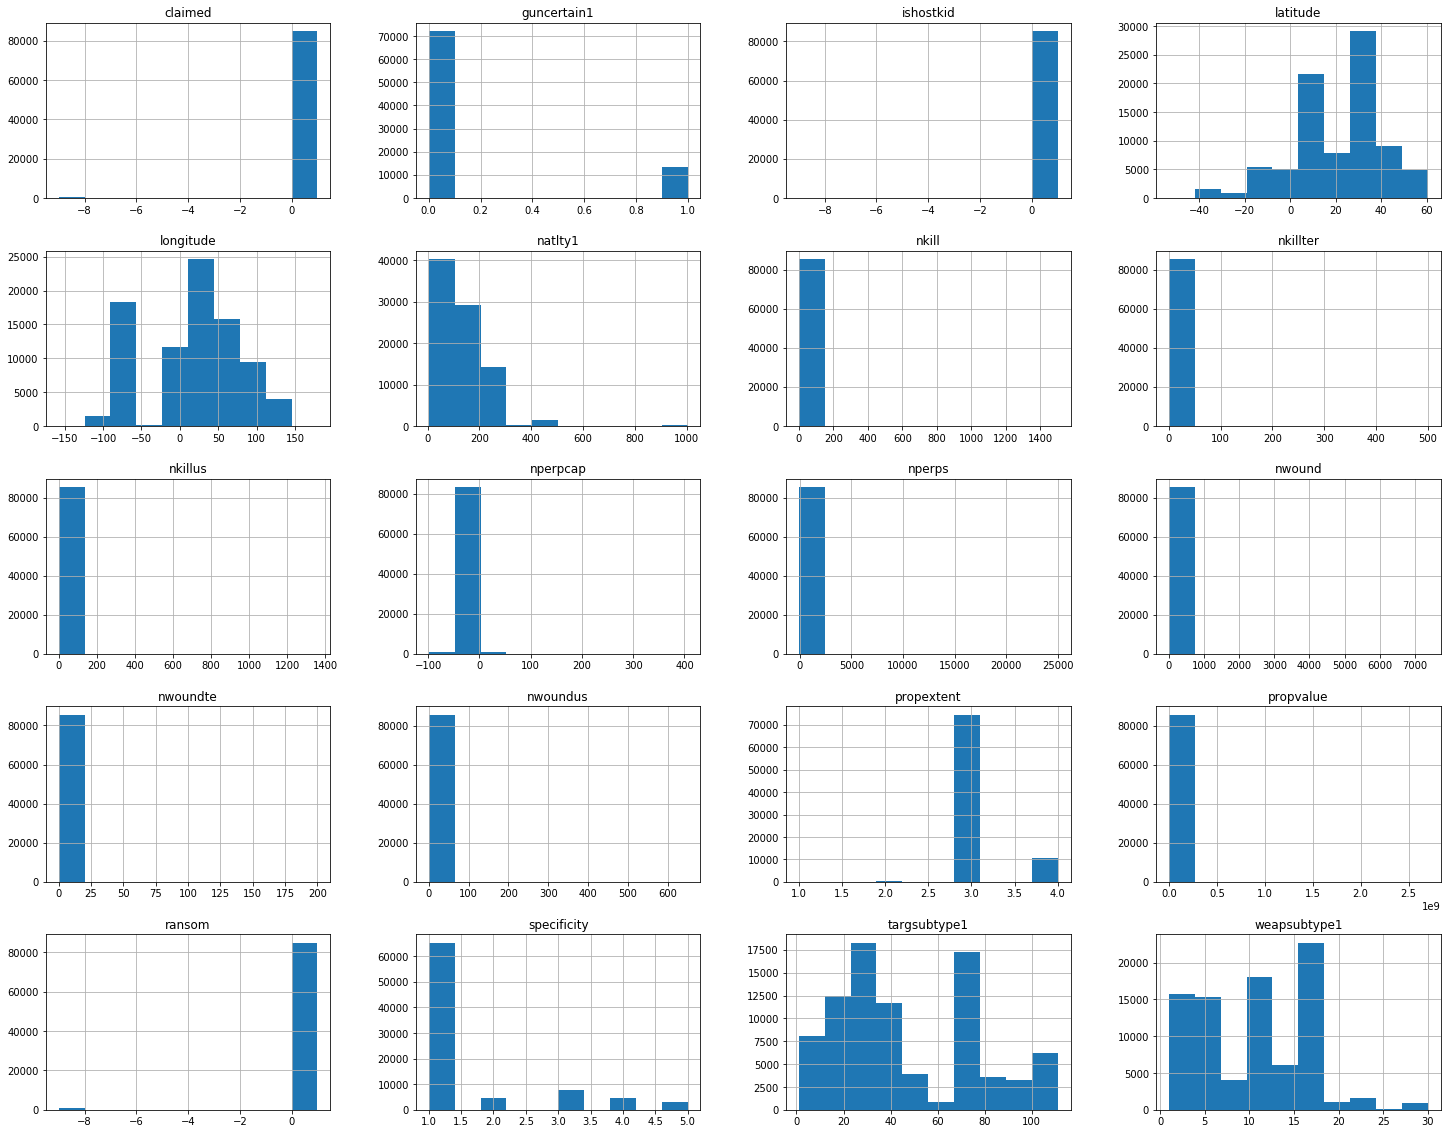

In [22]:
clean_data.hist(figsize=(25,20),layout=(5,4))
plt.show()

It can be noticed that most of the features are catergorical(i.e 0 or 1). We can see a wide range of nationalities represented by the natlty1, longitude and latidude features. We can also see wide range of wepons used, and also different types of targets. 

Below we are going to look at the correlation of features.

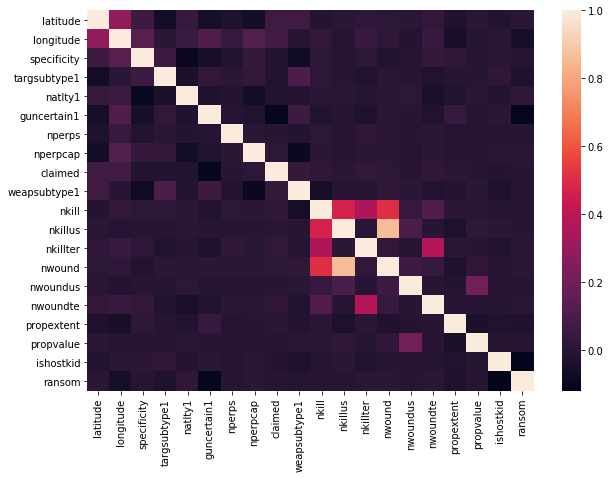

In [50]:
# Feature correletions
plt.figure(figsize=(10,7))
sns.heatmap(clean_data.corr())
plt.show()

This is a powerful plot from which a lot of inspiration about the data can be drawn. For example, we can see a possible correlation between b1 and b4 and b6 and hb6 just to note few. From this we are motivated to look at correlation matrix and find out which features are highly correleted so that we can remove one of them from the training set because is not giving any new additional information. In fact as result it may causes our algorithms to have low accuracy score on our test data. We can also note the relationship between each feature and the distribution of different classes.

#### Correleation matrix
We are going to compute correlation between all combination of features. The correlation coefficient will tell us how two features compare. The correlation coefficient value can be an value between -1 and 1. It is 1 if the correlated parameters are directly proportional, 0 if no correlation and -1 if correlated parameters are anti-correlated. We are going to drop all features which are highly correleted. We will drop all features with correleation coefficient which is greater that 0.95. In order to choose which feature to drop between highly correleted features we are going to look at features that has multiple correlations, and drop them. Features are highly correleted are not giving the learning algorithm any additional information.

In [24]:
# Create correlation matrix
corr_matrix =clean_data.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

#Dropping all highly correleted features.
no_corr = clean_data.drop(clean_data.columns[to_drop], axis=1)


In [25]:
print '========================================================================================================'
print 'Shape of the low correlection data:',no_corr.shape
print '========================================================================================================'

Shape of the low correlection data: (85522, 21)


We can note that all the features are retained, this tells us that there are no features with correlation coffiecient of greater that 0.95. The correlation between features is pretty much low.

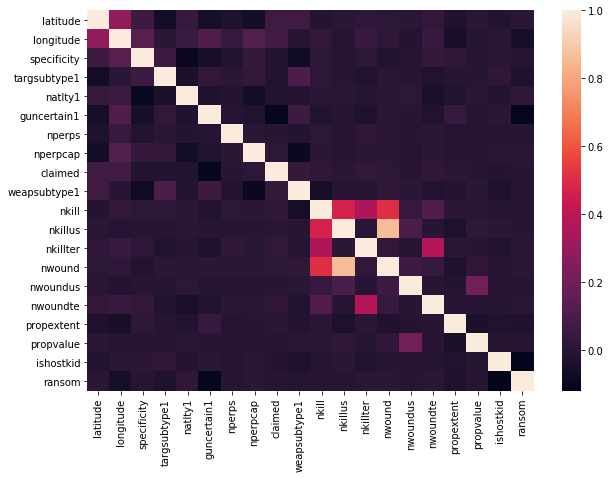

In [26]:
# Feature correletions
plt.figure(figsize=(10,7))
sns.heatmap(no_corr.corr())
plt.show()

To deal with high dimentinalty of feature space, we are going to make use of Analysis of variance (ANOVA) investigates the relationship between categorical independent variables and continuous dependent variables. It can be used to test whether the means of several groups are equal. The ANOVA table tells us the proportion of variance explained by the feature or groups of features to the total variance in the data. Obviously the features that explain the largest proportion of the variance should be retained.


In [27]:
#Encoding terrorist organisation with numerical values to train the data
features = clean_data.drop('target',axis=1)
target = clean_data["target"]
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(target)
gname_encoded = le.transform(target)

In [28]:
#Spliting data into training and testing test to cross validate trained 80/20 split model
from sklearn.cross_validation import train_test_split
# Using all the features
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    gname_encoded, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# Create an SelectKBest object to select features with three best ANOVA F-Values
fvalue_selector = SelectKBest(f_classif, k=3)
# Apply the SelectKBest object to the features and target
X_kbest = fvalue_selector.fit_transform(X_train,y_train)
# Test data
X_ktest = fvalue_selector.fit_transform(X_test,y_test)


## Training different types of Machine Learning Algorithm

## Random Forest Classifier

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size

In [30]:
# Creating a random forest classifier
rndm =  RandomForestClassifier(n_jobs=2,random_state=10,n_estimators=10,max_features=None)
# Training the classifier
rndm.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

## Model evaluation

Misclassification error rate: 0.239
The accuracy is:  76.08 %


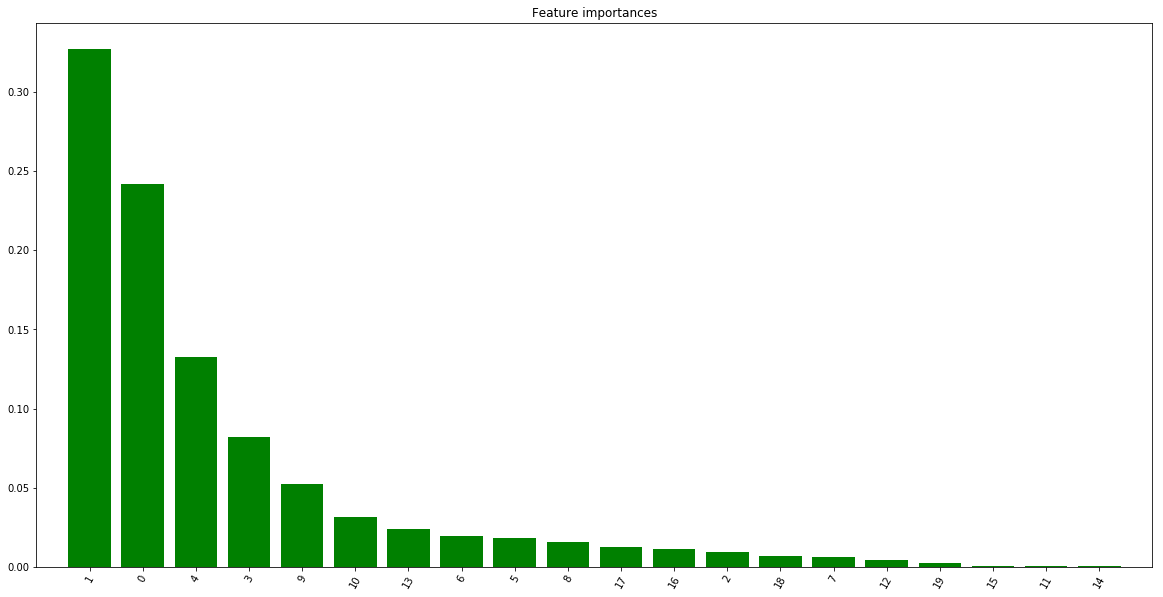

In [31]:
# Using the model to predict the unseen data
pred_rndm = rndm.predict(X_test)
# Creating confusion matrix
#print pd.crosstab(y_test, pred_rndm, rownames=['Actual clases'], colnames=['Predicted clases'])

# Computing error rate for the model
print '============================================================================================================'
print "Misclassification error rate:",round(np.mean(pred_rndm!=y_test),3)
print 'The accuracy is: ',round(accuracy_score(y_test,pred_rndm)*100,2),'%'
print '============================================================================================================'

# Looking at feature importance using random forest classifier
importances = rndm.feature_importances_
std = np.std([tree.feature_importances_ for tree in rndm.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", align="center")
plt.xticks(range(X_train.shape[1]), indices,rotation=60)
plt.xlim([-1, X_train.shape[1]])
plt.show()


### Considering only the important features
Now we are going to retain only features where their feature importance is greater than 0.1.

In [32]:
# Getting indeces where the feature importance is greater than 0.06
indices = np.where(importances>0.06)
# Extracting those features whose indices are greater than 0.06
X_trainF = np.array(X_train)[:,indices][:,0]
X_testF = np.array(X_test)[:, indices][:,0]

In [33]:
# Creating a random forest classifier
rndm =  RandomForestClassifier(n_jobs=2,random_state=10,n_estimators=10)
# Training the classifier
rndm.fit(X_trainF,y_train)

# Using the model to predict the unseen data
pred_rndm = rndm.predict(X_testF)

# Computing error rate for and the accuracy for the model
print '============================================================================================================'
print "Misclassification error rate:",round(np.mean(pred_rndm!=y_test),3)
print 'The accuracy is: ',round(accuracy_score(y_test,pred_rndm)*100,3),'%'
print '============================================================================================================'

Misclassification error rate: 0.279
The accuracy is:  72.148 %


#### Looking at  Analysis of variance method and F-value

In [34]:
# Creating a random forest classifier
rndm =  RandomForestClassifier(n_jobs=2,random_state=10,n_estimators=10)
# Training the classifier
rndm.fit(X_kbest,y_train)
# Using the model to predict the unseen data
pred_anova = rndm.predict(X_ktest)
# Creating confusion matrix
#print pd.crosstab(Y_test, pred_anova, rownames=['Actual clases'], colnames=['Predicted clases'])
# Computing error rate for the model
print '============================================================================================================'
print "Misclassification error rate:",round(np.mean(pred_anova!=y_test),3)
print 'The accuracy is: ',round(accuracy_score(y_test,pred_anova)*100,3),'%'
print '============================================================================================================'

Misclassification error rate: 0.286
The accuracy is:  71.441 %


It can be noticed that the high accuracy is obtained when we use all the features,followed by feature importance from random forest and lastly ANONA and yield the lowest accuracy.

## Support Vector Machine 
**Training the model using all the features**

In [35]:
# Creating SVM classifier
svms = svm.SVC()
# Training the classifier
svms.fit(X_train,y_train)
# Predicting using the unseen data
predi = svms.predict(X_test)
# Creating a confusion matrix
print '==========================================================================================================='
print "Misclassification error rate:",round(np.mean(predi!=y_test),3)
print 'The accuracy is: ',round(accuracy_score(y_test,predi)*100,3),'%'
print '==========================================================================================================='

Misclassification error rate: 0.412
The accuracy is:  58.831 %


**Training the model using features selected from RF classifer**

In [37]:
# RF features
svms.fit(X_trainF,y_train)
predic = svms.predict(X_testF)
print '==========================================================================================================='
print "Misclassification error rate:",round(np.mean(predic!=y_test),3)
print 'The accuracy is: ',round(accuracy_score(y_test,predic)*100,3),'%'
print '==========================================================================================================='

Misclassification error rate: 0.312
The accuracy is:  68.804 %


**ANOVA and F-value**

In [39]:
svms = svm.SVC()
svms.fit(X_kbest,y_train)
pred_f = svms.predict(X_ktest)

print '==========================================================================================================='
print "Misclassification error rate:",round(np.mean(pred_f!=y_test),3)
print 'The accuracy is: ',round(accuracy_score(y_test,pred_f)*100,3),'%'
print '==========================================================================================================='

Misclassification error rate: 0.317
The accuracy is:  68.319 %


## **Decision Tree Classifier**

Decision tree is a supervised learning algorithm. It works for both categorical and continuous input (features) and output (predicted) variables. Tree-based methods partition the feature space into a set of rectangles, and then fit a simple model (like a constant) in each one. They are conceptually simple yet powerful.

**Training using all the features**

In [45]:
# Creating a decision tree classifier
dtree = DecisionTreeClassifier(criterion='gini',max_depth=None)
dtree.fit(X_train,y_train)
pred_d = dtree.predict(X_test)
print '==========================================================================================================='
print "Misclassification error rate:",round(np.mean(pred_d!=y_test),3)
print 'The accuracy is: ',round(accuracy_score(y_test,pred_d)*100,2),'%'
print '==========================================================================================================='

Misclassification error rate: 0.28
The accuracy is:  72.03 %


#### RF features

In [46]:
# RF features
dtree.fit(X_trainF,y_train)
predic = dtree.predict(X_testF)
print '==========================================================================================================='
print "Misclassification error rate:",round(np.mean(predic!=y_test),3)
print 'The accuracy is: ',round(accuracy_score(y_test,predic)*100,3),'%'
print '==========================================================================================================='

Misclassification error rate: 0.297
The accuracy is:  70.278 %


**ANOVA and F-value features**

In [50]:
#ANOVA
dtree.fit(X_kbest,y_train)
predic = dtree.predict(X_ktest)

print '==========================================================================================================='
print "Misclassification error rate:",round(np.mean(predic!=y_test),3)
print 'The accuracy is: ',round(accuracy_score(y_test,predic)*100,3),'%'
print '==========================================================================================================='

Misclassification error rate: 0.297
The accuracy is:  70.289 %


## **KNeighbors classifier**


The k-nearest neighbour classifier, is **non-parametric** and it is an **instant based** algorithm.

- *Non-parametric* means it makes no explicit assumptions about the functional form of F, avoiding the dangers of mismodeling the underlying distribution of the data.

- *Instance-based* learning means that our algorithm doesn’t explicitly learn a model. Instead, it chooses to memorize the training instances which are subsequently used as “knowledge” for the prediction phase. 



The K-nearest neighbor algorithm essentially boils down to forming a majority vote between the K most similar instances to a given “unseen” observation. Similarity is defined according to a distance metric between two data points. A popular choice is the Euclidean distance given by
$$d(x,x') = \sqrt{(x_{1} - x'_{1})^{2} + (x_{2} - x'_{2})^{2} +...+ (x_{n} - x'_{n})^{2} } $$

but other measures can be more suitable for a given setting and include the Manhattan, Chebyshev and Hamming distance.

More formally, given a positive integer K, an unseen observation x and a similarity metric dd, KNN classifier performs the following two steps:

- It runs through the whole dataset computing dd between $x$ and each training observation. We’ll call the K points in the training data that are closest to $x$ the set X.

- It then estimates the conditional probability for each class, that is, the fraction of points in X with that given class label. 

$$P(y = j|X = x) = \frac{1}{K} \sum_{i → X}I(y^{i} = j) $$

where $I(x)$ is the indicator function which evaluates to 1 when the argument $x$ is true and 0 otherwise.

Finally, our input $x$ gets assigned to the class with the largest probability. An alternate way of understanding KNN is by thinking about it as calculating a decision boundary.



like most machine learning algorithms, the K in KNN is a hyperparameter that you, as a designer, must pick in order to get the best possible fit for the data set. Intuitively, you can think of K as controlling the shape of the decision boundary we talked about earlier.

When K is small, we are restraining the region of a given prediction and forcing our classifier to be “more blind” to the overall distribution. A small value for K provides the most flexible fit, which will have low bias but high variance. Graphically, our decision boundary will be more jagged.

On the other hand, a higher K averages more voters in each prediction and hence is more resilient to outliers. Larger values of K will have smoother decision boundaries which means lower variance but increased bias.



**Training using all the features**

In [48]:
error_rate = []
import seaborn as sns
% matplotlib inline
for i in range(1,60):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))


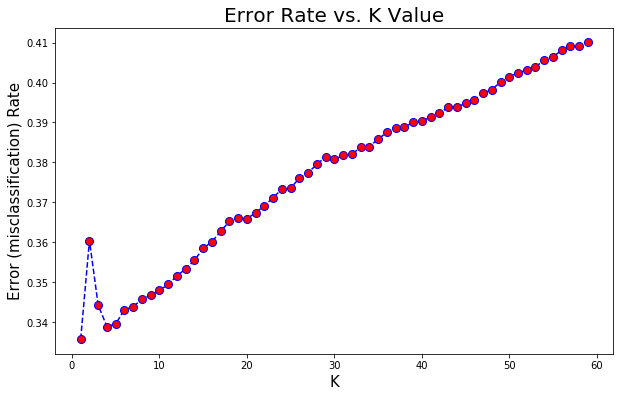

In [49]:
plt.figure(figsize=(10,6))
plt.plot(range(1,60),error_rate,color='blue', linestyle='dashed', marker='o',
    markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value', fontsize=20)
plt.xlabel('K',fontsize=15)
plt.ylabel('Error (misclassification) Rate',fontsize=15)
plt.show()

The error rate plot above indicate the lowest error rate that can be obtained by KNN is  about 33% with a k-value corrrepomding to 1 as shown on the plot. But at K=1, we were overfitting the boundaries. Hence, error rate initially decreases and reaches a minima. After the minima point, it then increase with increasing K.

In [42]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
pred_k = knn.predict(X_test)

print '==========================================================================================================='
print("Misclassification error rate:",round(np.mean(pred_k!=y_test),3))
print('The accuracy is: ',round(accuracy_score(y_test,pred_k)*100,3),'%')
print '==========================================================================================================='

('Misclassification error rate:', 0.339)
('The accuracy is: ', 66.115, '%')


**RF features**

In [40]:
# RF features
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_trainF,y_train)
pred_k = knn.predict(X_testF)
print '==========================================================================================================='
print "Misclassification error rate:",round(np.mean(pred_k!=y_test),3)
print 'The accuracy is: ',round(accuracy_score(y_test,pred_k)*100,3),'%'
print '==========================================================================================================='

Misclassification error rate: 0.317
The accuracy is:  68.337 %


#### ANOVA F-test

In [47]:
# ANOVA F-test
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_kbest,y_train)
pred_k = knn.predict(X_ktest)
print '==========================================================================================================='
print("Misclassification error rate:",round(np.mean(pred_k!=y_test),3))
print('The accuracy is: ',round(accuracy_score(y_test,pred_k)*100,3),'%')
print '==========================================================================================================='



('Misclassification error rate:', 0.313)
('The accuracy is: ', 68.699, '%')


In [51]:
# Summary of all the Classifier
from collections import OrderedDict
sales = OrderedDict( [('Models', ['Random Forest Clasifier', 'Support Vector Machines', 'Decison Tree classifier','KNeighbour']),
          ('Accuracy of all Features %', [76.08,58.83,72.05,66.12]),
          ('Accurary of RF best features %',[72.15,68.80,70.27,69.28]),
          ('Accuracy of ANOVA & F-test Features %', [71.44, 68.28,70.30,68.70])
          
          ])
df = pd.DataFrame.from_dict(sales)
df

,Models,Accuracy of all Features %,Accurary of RF best features %,Accuracy of ANOVA & F-test Features %
0,Random Forest Clasifier,76.08,72.15,71.44
1,Support Vector Machines,58.83,68.80,68.28
2,Decison Tree classifier,72.05,70.27,70.30
3,KNeighbour,66.12,69.28,68.70


## Conclusion
It can be noticed that for Random Forest Classifier did well in all feature space selected as compared to other three, followed by Decision Tree classifier, KNeighbour classifier and lastly the Support Vector Machine. As for the RF classifier we can note that the accuracy decreases as we do feature dimension reduction, which is the opposite with the SVM, we see an increase with accuracy as we do dimensionality reduction.